In [71]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataset_manipulation.dataloaders import DataLoaderFactory 
from PIL import Image
from io import BytesIO

In [3]:
data_path = '../data'

In [4]:
dlf = DataLoaderFactory(datadir=data_path, num_workers=1, pin_memory=True)

In [5]:
datasets_names = ['polymnist_unimodal','polymnist_multimodal','cub_caption','cub_image','cub_joint']

# Utils

## Text utils

In [56]:
maxSentLen = 32  # max length of any description for birds dataset
minOccur = 3

In [57]:
vocab_file = data_path + '/cub/oc:{}_msl:{}/cub.vocab'.format(minOccur, maxSentLen)

In [58]:
def load_vocab(vocab_file = vocab_file):
        # call dataloader function to create vocab file if it doesn't exist
        # if not os.path.exists(vocab_file):
        #     _, _ = self.getDataLoaders(256)
        with open(vocab_file, 'r') as vocab_file:
            vocab = json.load(vocab_file)
        return vocab['i2w']

In [59]:
i2w = load_vocab()

In [60]:
fn_trun = lambda s: s[:np.where(s == 2)[0][0] + 1] if 2 in s else s

In [61]:
fn_2i = lambda t: t.cpu().numpy().astype(int)

In [26]:
def sent_process(sentences):
        return [fn_trun(fn_2i(s)) for s in sentences]

## Visualization functions

In [10]:
def plot_PM_unimodal(labeled_data, n_samples, modality = 1):
    data, labels = labeled_data
    data = data[0]
    n_rows =  1
    n_cols = n_samples
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    
    for i in range(n_cols):
        ax = axes[i] #if n_images > 1 else axes[j]
        img = data[i].detach().cpu().numpy().transpose(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        # Label the top of each column with the modality number
        ax.set_title(f'{labels[i].item()}')
    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_PM(labeled_data, n_samples, n_modalities = 5):
    data, _ = labeled_data
    n_rows =  n_samples 
    n_cols = n_modalities 
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    
    for i in range(n_rows):
        for j in range(n_cols):
            if i ==0:
                axes[0][j].set_title(f'Modality {j+1}')
            ax = axes[i][j] 
            img = data[j][i].detach().cpu().numpy().transpose(1, 2, 0)
                
            ax.imshow(img)
            ax.axis('off')  # Turn off axis
            
    
    plt.tight_layout()
    plt.show()

In [12]:
def plot_CUB_Image(labeled_data, n_samples):
    data, labels = labeled_data
    n_rows =  1
    n_cols = n_samples
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    
    for i in range(n_cols):
        ax = axes[i] #if n_images > 1 else axes[j]
        img = data[i].detach().cpu().numpy().transpose(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')  # Turn off axis
        # Label the top of each column with the modality number
        ax.set_title(f'{labels[i].item()}')
    
    plt.tight_layout()
    plt.show()

In [77]:
# Helper function to plot captions so to smoothly log on WandB
def plot_text_as_image_tensor(sentences_lists_of_words, pixel_width=64, pixel_height=384):
    imgs = []
    for sentence in sentences_lists_of_words:
        px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
        fig = plt.figure(figsize=(pixel_width * px, pixel_height * px))
        plt.text(
            x=1,
            y=0.5,
            s='{}'.format(
                ' '.join(i + '\n' if (n + 1) % 1 == 0
                         else i for n, i in enumerate([word for word in sentence.split() if word != '<eos>']))),
            fontsize=7,
            verticalalignment='center_baseline',
            horizontalalignment='right'
        )
        plt.axis('off')

        # Draw the canvas
        fig.canvas.draw()

        # **Capture the canvas as an RGBA buffer**
        image_rgba = np.asarray(fig.canvas.buffer_rgba())  # This gives an RGBA array
        image_np = image_rgba[..., :3]  # Discard the alpha channel

        # Convert the NumPy array to a PyTorch tensor
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255  # Normalize to [0, 1]
        imgs.append(image_tensor)

        # Clean up the figure
        plt.close(fig)
    return torch.stack(imgs, dim=0)

In [14]:
def plot_sentences_as_tensor(batched_text_modality):
    """

    Args:
        batched_text_modality: Gets batch of text modality (as it is in input to forward function)

    Returns:
        Tensor with a corresponding plot containing the given text
    """
    sentences_processed = sent_process(batched_text_modality.argmax(-1))
    sentences_worded = [' '.join(i2w[str(word)] for word in sent if i2w[str(word)] != '<pad>') for sent in sentences_processed]
    return plot_text_as_image_tensor(sentences_worded, pixel_width=64, pixel_height=384)

In [15]:
def plot_CUB_text(data, n_samples):
    n_rows =  1
    n_cols = n_samples
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    for i in range(n_cols):
        ax = axes[i] #if n_images > 1 else axes[j]
        img = data[i].detach().cpu().numpy().transpose(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    plt.tight_layout()
    plt.show()

In [16]:
def plot_CUB_combined(image_labeled_data, text_data, n_samples):
    """
    Plots images and their corresponding text data in a single figure with two rows.

    Args:
        image_labeled_data (tuple): Tuple containing (image_tensor, labels).
            - image_tensor (torch.Tensor): Tensor of shape [batch_size, 3, H, W].
            - labels (torch.Tensor): Tensor of shape [batch_size].
        text_data (torch.Tensor): Tensor of shape [batch_size, C, H, W] or [batch_size, H, W].
        n_samples (int): Number of samples to display.

    Returns:
        None
    """
    # Unpack the image data and labels
    image_tensor, labels = image_labeled_data

    # Ensure we have enough samples
    if n_samples > len(image_tensor) or n_samples > len(text_data):
        raise ValueError("n_samples exceeds the number of available samples in the data.")

    # Slice the tensors to the desired number of samples
    image_tensor = image_tensor[:n_samples]
    labels = labels[:n_samples]
    text_data = text_data[:n_samples]

    # Set up the subplot grid with 2 rows and n_samples columns
    fig, axes = plt.subplots(2, n_samples, figsize=(3 * n_samples, 20), gridspec_kw={'height_ratios': [1, 4]})

    # Handle the case when n_samples is 1 (axes may not be a 2D array)
    if n_samples == 1:
        axes = axes.reshape(2, 1)

    for i in range(n_samples):
        # -------------------
        # Plot the Image
        # -------------------
        ax_img = axes[0, i]
        img = image_tensor[i].detach().cpu().numpy().transpose(1, 2, 0)
        ax_img.imshow(img)
        ax_img.axis('off')
        # ax_img.set_title(f'Label: {labels[i].item()}', fontsize=10)

        # -------------------
        # Plot the Text Data
        # -------------------
        ax_text = axes[1, i]
        text_img = text_data[i].detach().cpu().numpy()

        # Check the number of dimensions
        if text_img.ndim == 3:
            # Transpose the text image to (H, W, C)
            text_img = text_img.transpose(1, 2, 0)

        # Normalize the text data for better visualization (optional)
        text_img = (text_img - text_img.min()) / (text_img.max() - text_img.min() + 1e-5)

        # Plot the text image
        ax_text.imshow(text_img, aspect='auto')
        ax_text.axis('off')
        # ax_text.set_title('Text Data', fontsize=10)

    plt.tight_layout()
    plt.show()


# Polymnist

Polymnist is composed of 5 modalities with the same MNIST digit, each modality is defined by it's background theme (5 themes). 

In [19]:
num_modalities = 5
n_samples = 10

## Unimodal

In [27]:
train, test = dlf.get_dataloader('polymnist_unimodal', 16, modality=1)

/home/quintana/github/MM_Diffusion/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


plotting samples from modality 0


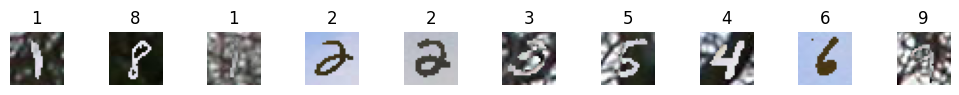

plotting samples from modality 1


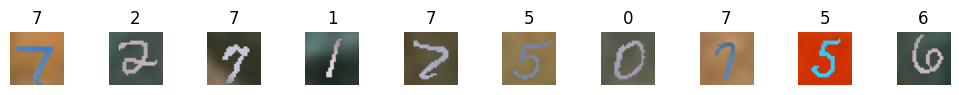

plotting samples from modality 2


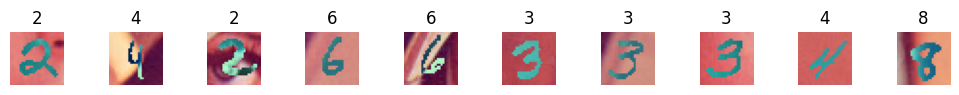

plotting samples from modality 3


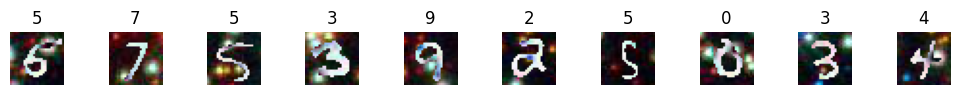

plotting samples from modality 4


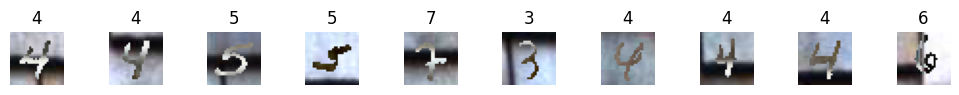

In [28]:
for modality in range(num_modalities):
    train, test = dlf.get_dataloader('polymnist_unimodal', 16, modality=modality)
    labeled_data = next(iter(train))
    print(f'plotting samples from modality {modality}')
    plot_PM_unimodal(labeled_data, n_samples, modality=modality)

## Multimodal

In [29]:
train, test = dlf.get_dataloader('polymnist_multimodal', n_samples)

In [30]:
labeled_data = next(iter(train))

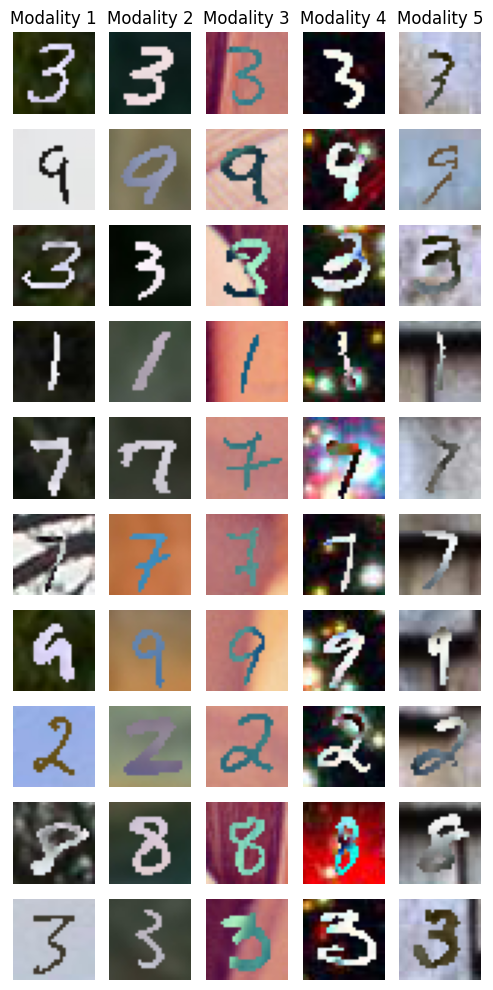

In [31]:
plot_PM(labeled_data, n_samples, n_modalities = num_modalities)

# Cub Image Caption

In [32]:
num_samples = 9

## Image

In [33]:
train, test = dlf.get_dataloader('cub_image', num_samples)

In [34]:
labeled_data = next(iter(train))

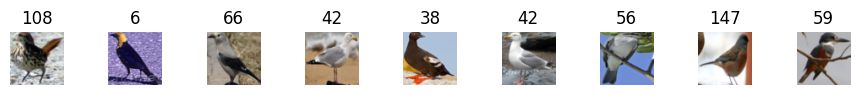

In [35]:
plot_CUB_Image(labeled_data, num_samples)

## Caption

In [48]:
train, test = dlf.get_dataloader('cub_caption', num_samples)

Data file not found for TRAIN split at ../data/cub/oc:3_msl:32/cub.train.s32. Creating new... (this may take a while)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


Vocablurary of 1590 keys created, 2100 words are excluded (occurrence <= 3).
2292 out of 88550 sentences are truncated with max sentence length 32.
Data file not found for TEST split at ../data/cub/oc:3_msl:32/cub.test.s32. Creating new... (this may take a while)
810 out of 29330 sentences are truncated with max sentence length 32.


In [49]:
one_hot_encoded_text, _  = next(iter(train))

In [75]:
text_image = plot_sentences_as_tensor(one_hot_encoded_text)

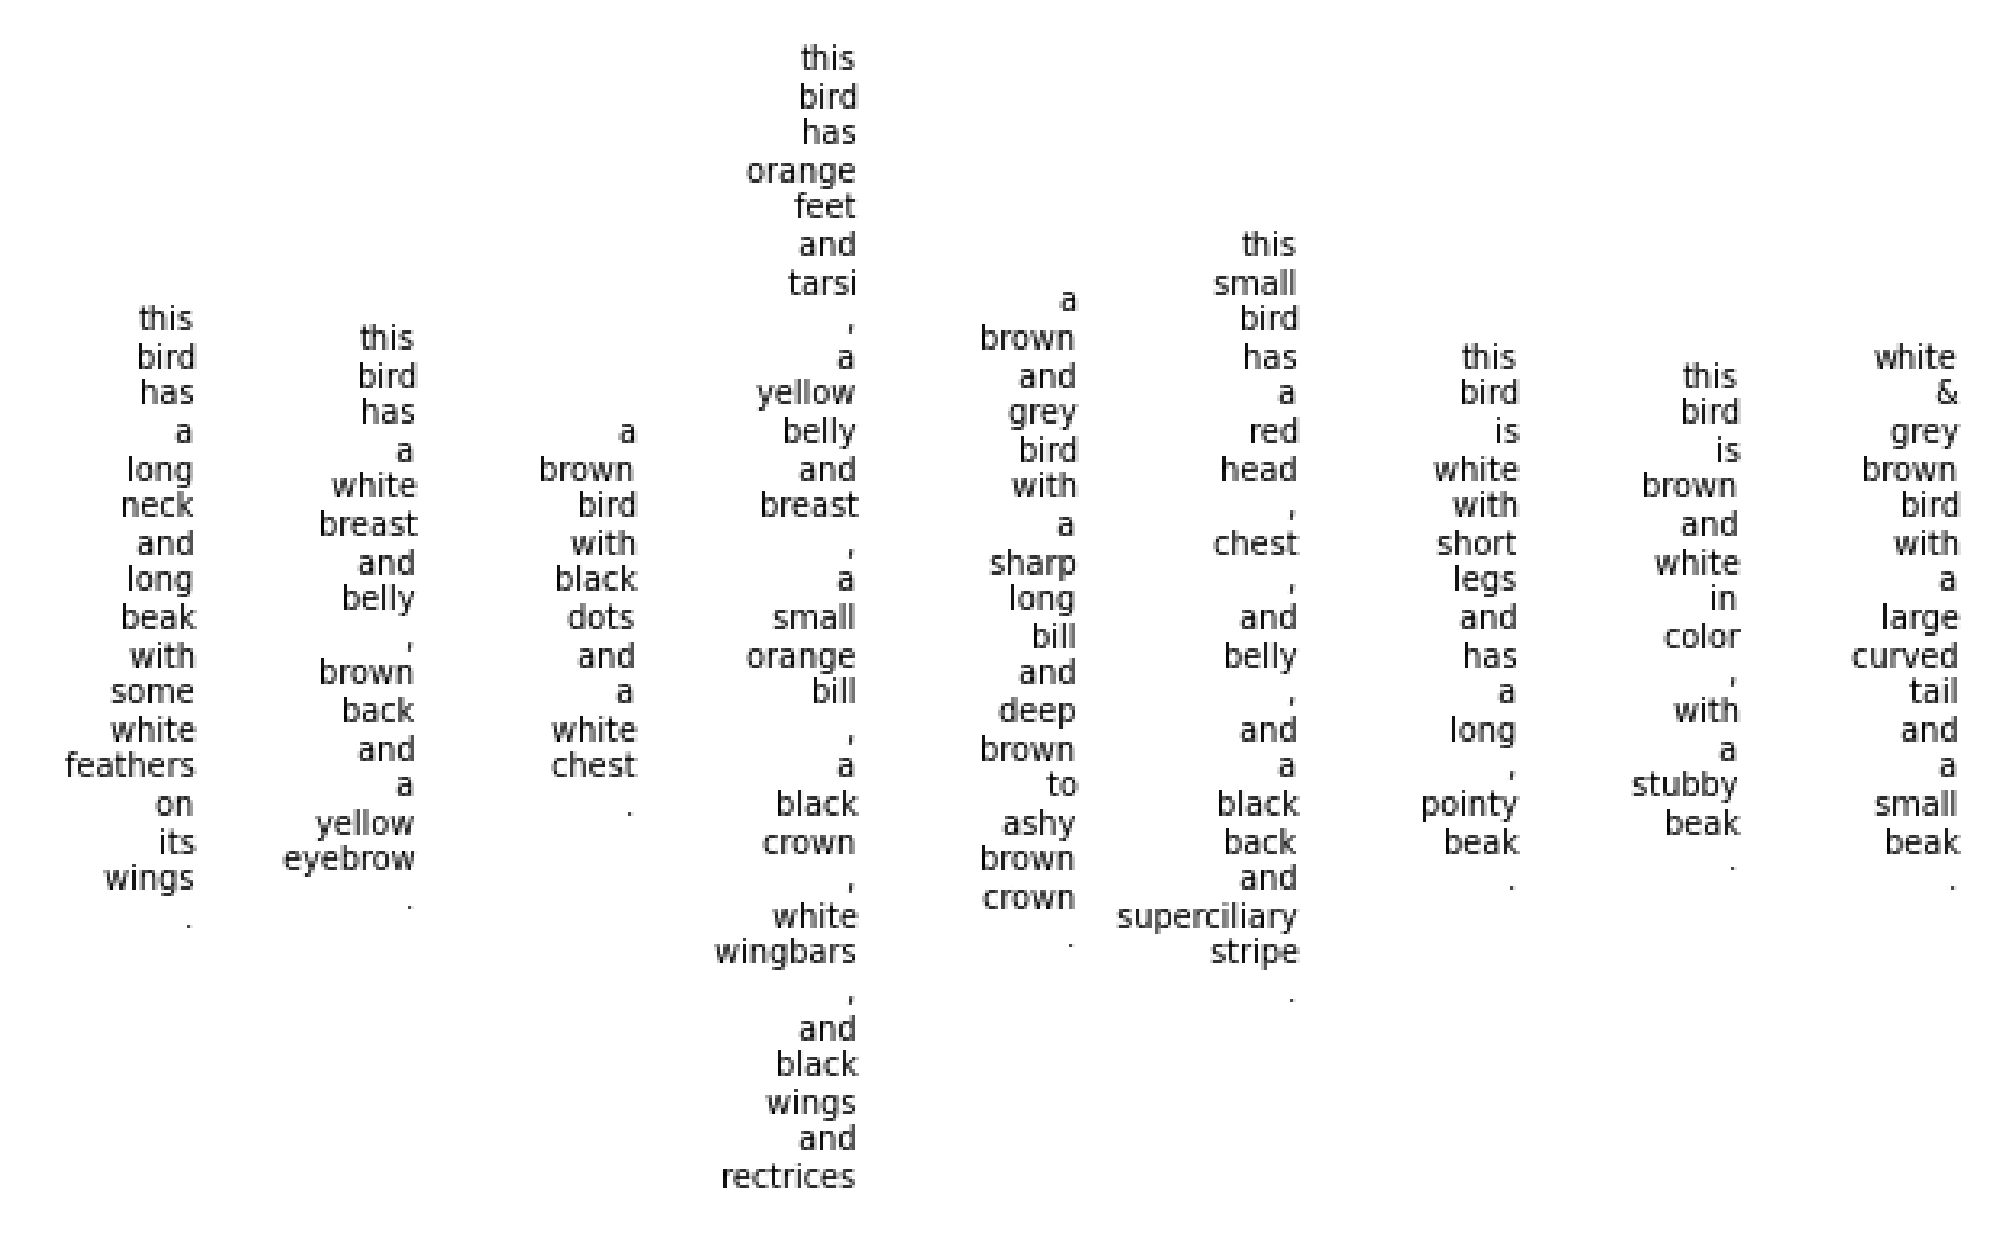

In [33]:
plot_CUB_text(text_image, num_samples)

## Image & Caption

In [52]:
train, test = dlf.get_dataloader('cub_joint', num_samples)

In [53]:
image,caption = next(iter(train))

In [76]:
caption_image = plot_sentences_as_tensor(caption[0])

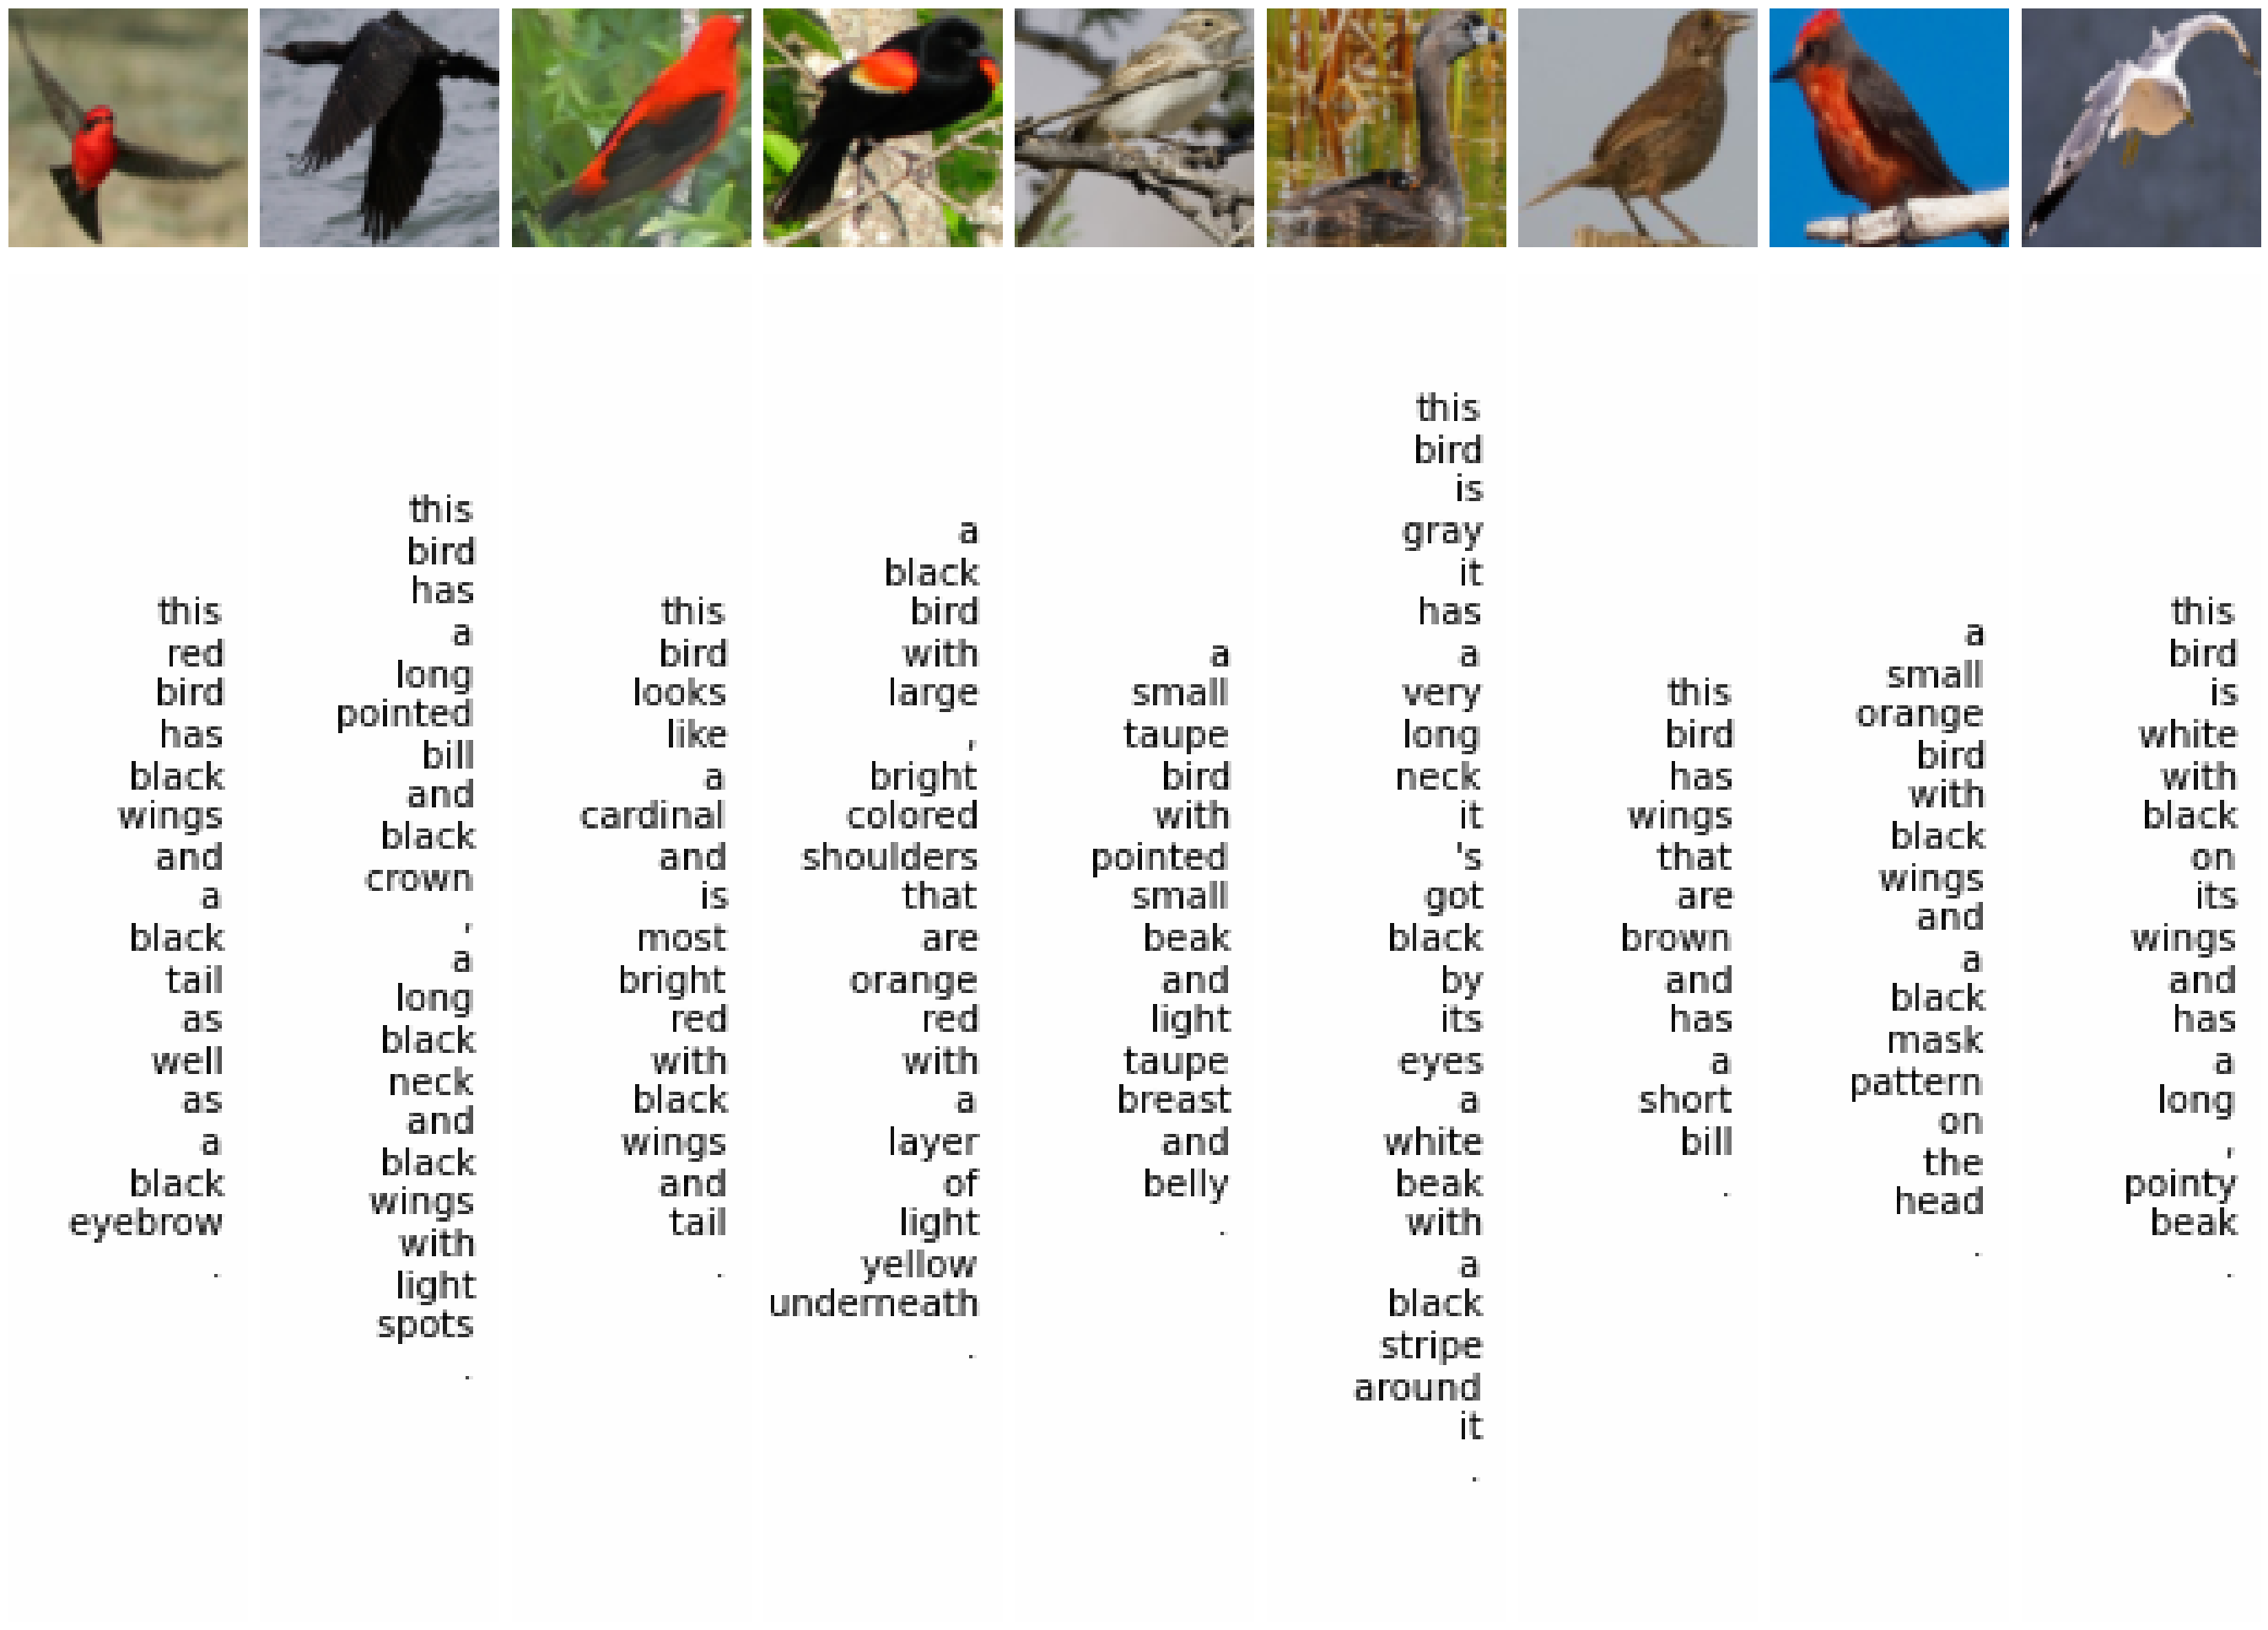

In [37]:
plot_CUB_combined(image,caption_image, num_samples )